# Use Adam till convergence point then use SGDM

In [1]:
!pip install wandb==0.9.7
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 8fce5ee4a321acdc93b1ab718535a737dc60ad84
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [2]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt
from PIL import Image
import wandb

device = torch.device("mps" if getattr(torch,'has_mps',False) else "cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

BATCH_SIZE = 256

cuda:0


## Import dataset

In [3]:
def load_data():
    img_shape = (32, 32)
    transform_train = transforms.Compose([
        transforms.Resize(img_shape, Image.BILINEAR),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,))
    ])
    transform_test = transforms.Compose([
        transforms.Resize(img_shape, Image.BILINEAR),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,))
    ])
    train_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_train)
    test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_test)
    print('Number of training data:', len(train_data))
    print('Number of testing data:', len(test_data))

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    return train_data, test_data, train_loader, test_loader
  
train_data, test_data, train_loader, test_loader = load_data()

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Number of training data: 50000
Number of testing data: 10000


## Build model

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(3, 32, 5, 1, 2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, 1, 2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(4096, 10, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [5]:
def train(model, train_loader, optimizer, loss_func, epochs):
    accuracy_lst_train = []
    loss_lst_train = []
    accuracy_lst_val = []
    loss_lst_val = []
    
    for epoch in tqdm(range(epochs), desc=f"Training progress", colour="#00ff00"):
        model.train()
        total_loss = 0
        correct = 0
        num_labels = 0
        counter = 0
        start_time = time.time()
        for batch_idx, (X, y) in enumerate(tqdm(train_loader, leave=False, desc=f"Epoch {epoch + 1}/{epochs}", colour="#005500")):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = loss_func(output, y)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == y).sum()
            num_labels += len(y)
            counter += 1
        accuracy_lst_train.append((correct/num_labels).cpu().item())
        loss_lst_train.append(total_loss/counter)

        # Validation
        model.eval()
        total_loss_val = 0
        correct_val = 0
        num_labels_val = 0
        counter_val = 0
        model.eval()
        for batch_idx, (X, y) in enumerate(test_loader):
            X = X.to(device)
            y = y.to(device)

            output = model(X)

            loss = loss_func(output, y)
            total_loss_val += loss.item()

            predicted = torch.max(output,1)[1]
            correct_val += (predicted == y).sum()
            num_labels_val += len(y)
            counter_val += 1
        loss_lst_val.append(total_loss_val/counter_val)
        accuracy_lst_val.append((correct_val/num_labels_val).cpu().item())

        # Log
        wandb.log({'Training Accuracy': accuracy_lst_train[-1], 'Training Loss': loss_lst_train[-1], 'Testing Accuracy': accuracy_lst_val[-1], 'Testing Loss': loss_lst_val[-1]})

        print('Epoch %d, Training Loss %4f, Training Accuracy %4f, Testing Loss %4f, Testing Accuracy %4f'
            % (epoch+1, total_loss/counter, correct/num_labels, total_loss_val/counter_val, correct_val/num_labels_val))
    return accuracy_lst_train, loss_lst_train, accuracy_lst_val, loss_lst_val

In [6]:
def evaluate(model, test_loader, loss_func):
    total_loss = 0
    correct = 0
    num_labels = 0
    counter = 0
    model.eval()
    for batch_idx, (X, y) in enumerate(test_loader):
        X = X.to(device)
        y = y.to(device)

        output = model(X)

        loss = loss_func(output, y)
        total_loss += loss.item()

        predicted = torch.max(output,1)[1]
        correct += (predicted == y).sum()
        num_labels += len(y)
        counter += 1
    print('Test Loss %4f, Test Accuracy %4f' % (total_loss/counter, correct/num_labels))

## Training

In [7]:
lr = 0.001

model = CNN().to(device)
print(model)

loss_func = nn.CrossEntropyLoss()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=4096, out_features=10, bias=False)
)


### Adam

In [8]:
num_epoch=60

In [9]:
# Adam

optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=5e-4)
Adam_run = wandb.init(project="CSI 5340 Project", entity="csi5340", name='AdamSGD')
wandb.watch(model, log="all", log_freq=10)

accuracy_lst_train, loss_lst_train, accuracy_lst_val, loss_lst_val = train(model, train_loader, optimizer, loss_func, num_epoch)
#evaluate(model, test_loader, loss_func)
# Adam_run.finish()

wandb: Wandb version 0.13.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training progress:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60:   0%|          | 0/196 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 1, Training Loss 1.632254, Training Accuracy 0.418400, Testing Loss 1.833456, Testing Accuracy 0.396200


Epoch 2/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Training Loss 1.248437, Training Accuracy 0.557180, Testing Loss 1.218373, Testing Accuracy 0.580200


Epoch 3/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Training Loss 1.130158, Training Accuracy 0.601960, Testing Loss 1.306480, Testing Accuracy 0.537600


Epoch 4/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Training Loss 1.065818, Training Accuracy 0.626940, Testing Loss 0.958983, Testing Accuracy 0.666000


Epoch 5/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Training Loss 1.011373, Training Accuracy 0.647480, Testing Loss 1.206611, Testing Accuracy 0.608300


Epoch 6/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Training Loss 0.964401, Training Accuracy 0.665740, Testing Loss 1.342715, Testing Accuracy 0.564600


Epoch 7/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Training Loss 0.918034, Training Accuracy 0.680440, Testing Loss 0.987981, Testing Accuracy 0.654100


Epoch 8/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Training Loss 0.895219, Training Accuracy 0.689300, Testing Loss 0.896846, Testing Accuracy 0.690600


Epoch 9/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Training Loss 0.881914, Training Accuracy 0.696320, Testing Loss 0.928660, Testing Accuracy 0.677900


Epoch 10/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Training Loss 0.857860, Training Accuracy 0.700740, Testing Loss 0.878224, Testing Accuracy 0.693200


Epoch 11/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Training Loss 0.843054, Training Accuracy 0.707880, Testing Loss 0.868723, Testing Accuracy 0.705800


Epoch 12/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Training Loss 0.813290, Training Accuracy 0.721240, Testing Loss 0.879827, Testing Accuracy 0.694300


Epoch 13/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Training Loss 0.806433, Training Accuracy 0.719700, Testing Loss 0.866833, Testing Accuracy 0.699600


Epoch 14/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Training Loss 0.792223, Training Accuracy 0.725240, Testing Loss 0.861475, Testing Accuracy 0.703600


Epoch 15/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Training Loss 0.781272, Training Accuracy 0.729560, Testing Loss 0.942071, Testing Accuracy 0.692100


Epoch 16/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Training Loss 0.771045, Training Accuracy 0.733540, Testing Loss 1.102242, Testing Accuracy 0.640600


Epoch 17/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Training Loss 0.766018, Training Accuracy 0.736300, Testing Loss 0.920623, Testing Accuracy 0.696500


Epoch 18/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Training Loss 0.752997, Training Accuracy 0.741340, Testing Loss 0.816034, Testing Accuracy 0.723700


Epoch 19/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Training Loss 0.748465, Training Accuracy 0.743760, Testing Loss 0.924500, Testing Accuracy 0.694000


Epoch 20/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Training Loss 0.734750, Training Accuracy 0.746640, Testing Loss 0.831590, Testing Accuracy 0.719800


Epoch 21/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, Training Loss 0.727362, Training Accuracy 0.749640, Testing Loss 0.859032, Testing Accuracy 0.718100


Epoch 22/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, Training Loss 0.715563, Training Accuracy 0.754520, Testing Loss 0.856927, Testing Accuracy 0.710000


Epoch 23/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, Training Loss 0.717314, Training Accuracy 0.755260, Testing Loss 0.841774, Testing Accuracy 0.724100


Epoch 24/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, Training Loss 0.712887, Training Accuracy 0.756180, Testing Loss 0.707578, Testing Accuracy 0.757300


Epoch 25/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, Training Loss 0.702696, Training Accuracy 0.757640, Testing Loss 0.949770, Testing Accuracy 0.688100


Epoch 26/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, Training Loss 0.703706, Training Accuracy 0.757080, Testing Loss 0.811557, Testing Accuracy 0.732800


Epoch 27/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, Training Loss 0.683710, Training Accuracy 0.765240, Testing Loss 0.685885, Testing Accuracy 0.769500


Epoch 28/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, Training Loss 0.689083, Training Accuracy 0.762400, Testing Loss 0.844426, Testing Accuracy 0.717000


Epoch 29/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, Training Loss 0.691614, Training Accuracy 0.761820, Testing Loss 0.743810, Testing Accuracy 0.744500


Epoch 30/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, Training Loss 0.678131, Training Accuracy 0.766220, Testing Loss 0.841586, Testing Accuracy 0.717900


Epoch 31/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31, Training Loss 0.673593, Training Accuracy 0.767460, Testing Loss 0.717685, Testing Accuracy 0.758300


Epoch 32/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32, Training Loss 0.666368, Training Accuracy 0.771320, Testing Loss 0.752249, Testing Accuracy 0.745600


Epoch 33/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33, Training Loss 0.665049, Training Accuracy 0.773780, Testing Loss 0.861624, Testing Accuracy 0.706200


Epoch 34/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34, Training Loss 0.657796, Training Accuracy 0.773860, Testing Loss 0.805475, Testing Accuracy 0.730000


Epoch 35/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35, Training Loss 0.653188, Training Accuracy 0.774280, Testing Loss 0.918791, Testing Accuracy 0.698200


Epoch 36/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36, Training Loss 0.647517, Training Accuracy 0.777400, Testing Loss 0.875736, Testing Accuracy 0.703900


Epoch 37/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37, Training Loss 0.642041, Training Accuracy 0.778140, Testing Loss 0.885985, Testing Accuracy 0.711000


Epoch 38/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38, Training Loss 0.648557, Training Accuracy 0.777960, Testing Loss 0.788059, Testing Accuracy 0.739500


Epoch 39/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39, Training Loss 0.637296, Training Accuracy 0.781800, Testing Loss 0.751724, Testing Accuracy 0.754600


Epoch 40/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40, Training Loss 0.644451, Training Accuracy 0.778440, Testing Loss 0.750677, Testing Accuracy 0.747100


Epoch 41/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41, Training Loss 0.634496, Training Accuracy 0.783180, Testing Loss 0.827689, Testing Accuracy 0.731300


Epoch 42/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42, Training Loss 0.636530, Training Accuracy 0.781960, Testing Loss 0.759262, Testing Accuracy 0.753600


Epoch 43/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43, Training Loss 0.636205, Training Accuracy 0.780160, Testing Loss 0.740118, Testing Accuracy 0.752300


Epoch 44/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44, Training Loss 0.623247, Training Accuracy 0.784680, Testing Loss 0.722673, Testing Accuracy 0.764700


Epoch 45/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45, Training Loss 0.625933, Training Accuracy 0.782140, Testing Loss 0.712696, Testing Accuracy 0.764800


Epoch 46/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46, Training Loss 0.620155, Training Accuracy 0.787320, Testing Loss 0.840505, Testing Accuracy 0.717800


Epoch 47/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47, Training Loss 0.618603, Training Accuracy 0.787260, Testing Loss 0.743405, Testing Accuracy 0.750900


Epoch 48/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48, Training Loss 0.614118, Training Accuracy 0.791600, Testing Loss 0.714125, Testing Accuracy 0.757500


Epoch 49/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49, Training Loss 0.612264, Training Accuracy 0.789160, Testing Loss 0.683670, Testing Accuracy 0.758400


Epoch 50/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50, Training Loss 0.613424, Training Accuracy 0.786660, Testing Loss 0.670761, Testing Accuracy 0.772100


Epoch 51/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 51, Training Loss 0.604603, Training Accuracy 0.791000, Testing Loss 0.651654, Testing Accuracy 0.779100


Epoch 52/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 52, Training Loss 0.609363, Training Accuracy 0.789480, Testing Loss 0.667642, Testing Accuracy 0.773800


Epoch 53/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 53, Training Loss 0.610306, Training Accuracy 0.789340, Testing Loss 0.680229, Testing Accuracy 0.766100


Epoch 54/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 54, Training Loss 0.599794, Training Accuracy 0.794360, Testing Loss 0.964739, Testing Accuracy 0.688600


Epoch 55/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 55, Training Loss 0.604246, Training Accuracy 0.794000, Testing Loss 0.613389, Testing Accuracy 0.788700


Epoch 56/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 56, Training Loss 0.600100, Training Accuracy 0.792860, Testing Loss 0.740343, Testing Accuracy 0.759000


Epoch 57/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 57, Training Loss 0.597928, Training Accuracy 0.793300, Testing Loss 0.697009, Testing Accuracy 0.760200


Epoch 58/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 58, Training Loss 0.596295, Training Accuracy 0.794100, Testing Loss 0.748198, Testing Accuracy 0.754500


Epoch 59/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 59, Training Loss 0.597591, Training Accuracy 0.794240, Testing Loss 0.664706, Testing Accuracy 0.768500


Epoch 60/60:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 60, Training Loss 0.592177, Training Accuracy 0.797880, Testing Loss 0.616718, Testing Accuracy 0.789100


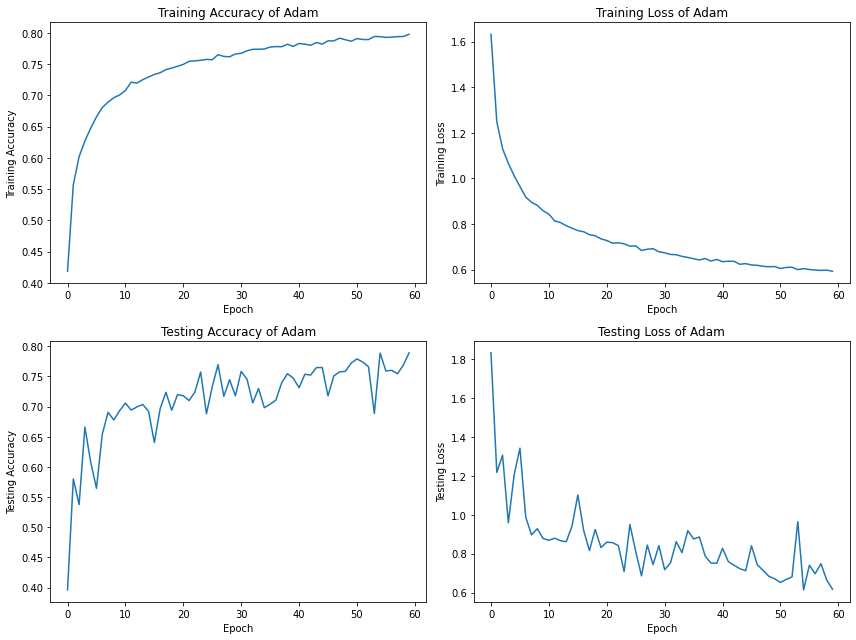

In [10]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(num_epoch), accuracy_lst_train)
axs[0, 0].set_title('Training Accuracy of Adam')
axs[0, 0].set(xlabel='Epoch', ylabel='Training Accuracy')

axs[0, 1].plot(range(num_epoch), loss_lst_train)
axs[0, 1].set_title('Training Loss of Adam')
axs[0, 1].set(xlabel='Epoch', ylabel='Training Loss')

axs[1, 0].plot(range(num_epoch), accuracy_lst_val)
axs[1, 0].set_title('Testing Accuracy of Adam')
axs[1, 0].set(xlabel='Epoch', ylabel='Testing Accuracy')

axs[1, 1].plot(range(num_epoch), loss_lst_val)
axs[1, 1].set_title('Testing Loss of Adam')
axs[1, 1].set(xlabel='Epoch', ylabel='Testing Loss')

fig.set_size_inches(12, 9)
fig.tight_layout()

### SGDM

In [11]:
num_epoch=40

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.95, weight_decay=5e-4)

accuracy_lst_train, loss_lst_train, accuracy_lst_val, loss_lst_val = train(model, train_loader, optimizer, loss_func, num_epoch)

#evaluate(model, test_loader, loss_func)
#Adam_run.finish()


Training progress:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/40:   0%|          | 0/196 [00:00<?, ?it/s]

wandb: Wandb version 0.13.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1, Training Loss 0.555506, Training Accuracy 0.810940, Testing Loss 0.606098, Testing Accuracy 0.795700


Epoch 2/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Training Loss 0.541267, Training Accuracy 0.814460, Testing Loss 0.583540, Testing Accuracy 0.801500


Epoch 3/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Training Loss 0.535079, Training Accuracy 0.816760, Testing Loss 0.596997, Testing Accuracy 0.793500


Epoch 4/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Training Loss 0.532636, Training Accuracy 0.817240, Testing Loss 0.711256, Testing Accuracy 0.758600


Epoch 5/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Training Loss 0.523764, Training Accuracy 0.822360, Testing Loss 0.595405, Testing Accuracy 0.797600


Epoch 6/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Training Loss 0.523420, Training Accuracy 0.822060, Testing Loss 0.706104, Testing Accuracy 0.756100


Epoch 7/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Training Loss 0.530487, Training Accuracy 0.817540, Testing Loss 0.694884, Testing Accuracy 0.763600


Epoch 8/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Training Loss 0.524029, Training Accuracy 0.821300, Testing Loss 0.562298, Testing Accuracy 0.806900


Epoch 9/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Training Loss 0.522787, Training Accuracy 0.820540, Testing Loss 0.565361, Testing Accuracy 0.810600


Epoch 10/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Training Loss 0.520316, Training Accuracy 0.824520, Testing Loss 0.573314, Testing Accuracy 0.803900


Epoch 11/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Training Loss 0.521106, Training Accuracy 0.822500, Testing Loss 0.580909, Testing Accuracy 0.802200


Epoch 12/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Training Loss 0.517343, Training Accuracy 0.821740, Testing Loss 0.592841, Testing Accuracy 0.796700


Epoch 13/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Training Loss 0.508912, Training Accuracy 0.825200, Testing Loss 0.685484, Testing Accuracy 0.764700


Epoch 14/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Training Loss 0.512712, Training Accuracy 0.824640, Testing Loss 0.569379, Testing Accuracy 0.806600


Epoch 15/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Training Loss 0.511190, Training Accuracy 0.824960, Testing Loss 0.540711, Testing Accuracy 0.816400


Epoch 16/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Training Loss 0.513056, Training Accuracy 0.823420, Testing Loss 0.596937, Testing Accuracy 0.798500


Epoch 17/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Training Loss 0.511660, Training Accuracy 0.823940, Testing Loss 0.671866, Testing Accuracy 0.774800


Epoch 18/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Training Loss 0.510279, Training Accuracy 0.825060, Testing Loss 0.602604, Testing Accuracy 0.796400


Epoch 19/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Training Loss 0.505172, Training Accuracy 0.827180, Testing Loss 0.572289, Testing Accuracy 0.803500


Epoch 20/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Training Loss 0.501360, Training Accuracy 0.826560, Testing Loss 0.587104, Testing Accuracy 0.800600


Epoch 21/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, Training Loss 0.506667, Training Accuracy 0.825760, Testing Loss 0.598971, Testing Accuracy 0.796300


Epoch 22/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, Training Loss 0.504873, Training Accuracy 0.828140, Testing Loss 0.664935, Testing Accuracy 0.772900


Epoch 23/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, Training Loss 0.509007, Training Accuracy 0.826620, Testing Loss 0.635452, Testing Accuracy 0.786500


Epoch 24/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, Training Loss 0.502109, Training Accuracy 0.826520, Testing Loss 0.679328, Testing Accuracy 0.769400


Epoch 25/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, Training Loss 0.504862, Training Accuracy 0.826620, Testing Loss 0.645867, Testing Accuracy 0.777300


Epoch 26/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, Training Loss 0.498317, Training Accuracy 0.828480, Testing Loss 0.564907, Testing Accuracy 0.808400


Epoch 27/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, Training Loss 0.505830, Training Accuracy 0.827580, Testing Loss 0.731540, Testing Accuracy 0.756300


Epoch 28/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, Training Loss 0.497106, Training Accuracy 0.829620, Testing Loss 0.579478, Testing Accuracy 0.799800


Epoch 29/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, Training Loss 0.499648, Training Accuracy 0.829140, Testing Loss 0.756732, Testing Accuracy 0.748300


Epoch 30/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, Training Loss 0.497784, Training Accuracy 0.830380, Testing Loss 0.679826, Testing Accuracy 0.775200


Epoch 31/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31, Training Loss 0.495522, Training Accuracy 0.830600, Testing Loss 0.620974, Testing Accuracy 0.790000


Epoch 32/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32, Training Loss 0.500152, Training Accuracy 0.827280, Testing Loss 0.563820, Testing Accuracy 0.811000


Epoch 33/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33, Training Loss 0.497885, Training Accuracy 0.829900, Testing Loss 0.619059, Testing Accuracy 0.791100


Epoch 34/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34, Training Loss 0.497041, Training Accuracy 0.829180, Testing Loss 0.639107, Testing Accuracy 0.781100


Epoch 35/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35, Training Loss 0.496020, Training Accuracy 0.828920, Testing Loss 0.572029, Testing Accuracy 0.805800


Epoch 36/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36, Training Loss 0.494050, Training Accuracy 0.831600, Testing Loss 0.674507, Testing Accuracy 0.770100


Epoch 37/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37, Training Loss 0.495359, Training Accuracy 0.829960, Testing Loss 0.578765, Testing Accuracy 0.798400


Epoch 38/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38, Training Loss 0.494693, Training Accuracy 0.829660, Testing Loss 0.537687, Testing Accuracy 0.816200


Epoch 39/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39, Training Loss 0.494299, Training Accuracy 0.830980, Testing Loss 0.531818, Testing Accuracy 0.819300


Epoch 40/40:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40, Training Loss 0.490377, Training Accuracy 0.831340, Testing Loss 0.575417, Testing Accuracy 0.802400


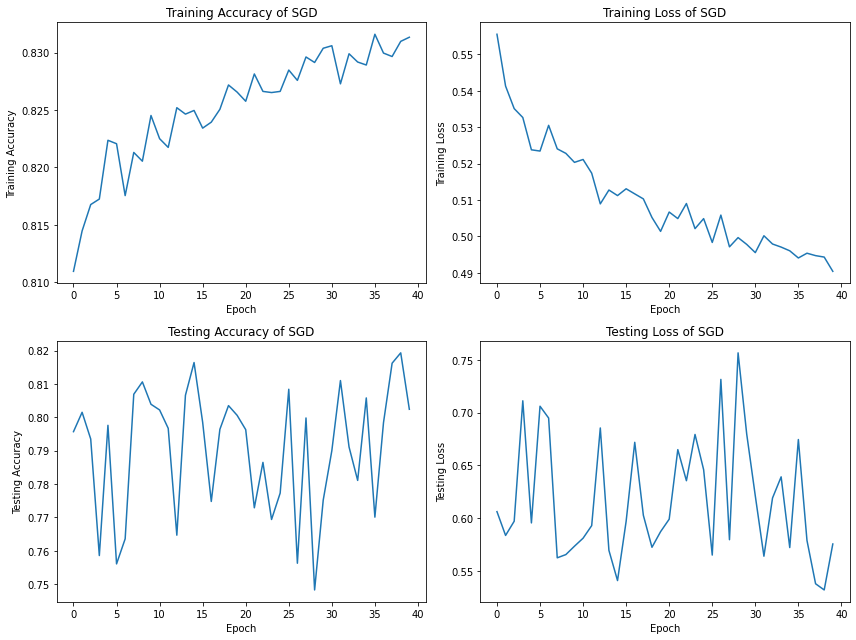

In [13]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(num_epoch), accuracy_lst_train)
axs[0, 0].set_title('Training Accuracy of SGD')
axs[0, 0].set(xlabel='Epoch', ylabel='Training Accuracy')

axs[0, 1].plot(range(num_epoch), loss_lst_train)
axs[0, 1].set_title('Training Loss of SGD')
axs[0, 1].set(xlabel='Epoch', ylabel='Training Loss')

axs[1, 0].plot(range(num_epoch), accuracy_lst_val)
axs[1, 0].set_title('Testing Accuracy of SGD')
axs[1, 0].set(xlabel='Epoch', ylabel='Testing Accuracy')

axs[1, 1].plot(range(num_epoch), loss_lst_val)
axs[1, 1].set_title('Testing Loss of SGD')
axs[1, 1].set(xlabel='Epoch', ylabel='Testing Loss')

fig.set_size_inches(12, 9)
fig.tight_layout()